# Zillow: Predicting Logerror


Presented By: Kristine Cabanela, David Rodriguez

January 13, 2021


# Project Goal

- In this project, our overall goal is to identify key drivers of logerror for single family properties in the Zillow dataset. The focus will be the single unit properties that had a transaction during 2017.


### Imports

In [1]:
# Below are imports of python modules and/or libraries necessary for analysis
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import wrangle
import warnings
warnings.filterwarnings('ignore')

# Acquire and Prep - Wrangle

### Get data by creating a function that connects to the SQL server
- Acquire data by using a SQL query to Zillow table in the mySQL database.


In [2]:
# Acquired dataset from stored module and assigned as df

df = wrangle.get_zillow()
df.head()


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,None,NaN,3.5,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,None,NaN,6.059063e+13,0.025595
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,None,NaN,1.0,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,None,NaN,6.111001e+13,0.055619
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,None,NaN,6.059022e+13,0.005383
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,None,8.0,3.0,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13,-0.103410
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,None,9.0,3.0,...,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,None,NaN,6.037461e+13,-0.001011


In [3]:
# There are 52441 columns and 60 rows in this dataset

df.shape

(52441, 60)

# Prepare
### Perform a data cleanup:
- To ensure that the data we are evaluating is at a high quality meaning it is free of incorrect, irrelevant, or incomplete information which will minimize the risk of wrong or inaccurate conclusions.

## Steps

- After aquiring dataset using a SQL query to Zillow table in the mySQL database, we looked at an overall overview of the dataset by looking at the number of columns and rows, whether any columns had null values and how many, and what the datatypes were for said columns so that we can familiarize ourselves with the dataset.
- With review of the dataset, there were are a significant amount of null values found in more than half our columns
- Firstly, we went ahead and dropped columns with missing values greater than 20%
- We removed the rest of the null values and confirmed there are now 0 nulls. 
- Next, we dropped the following columns: id, parcelid, propertycountylandusecode, regionidcity, regionidcounty, finishedsquarefeet12, fullbathcnt, calculatedbathnbr, and assessmentyear as they were insignificant to logerror
- We've found some outliers and we will drop those too
- Created a new column using fips to show column for counties
- After data cleanup a function was created for updated prepped Zillow data

## Takeaways
- Original dataset 52,441 columns and 60 rows in this dataset
- More than half of the columns were dropped because more than 50% of the column had null values.
- After prepping original acquired dataset, we are left with 47,897 columns and 17 rows in this dataset

In [4]:
# Displayed is our already prepped dataset 

wrangle_zillow = wrangle.wrangle_zillow()
wrangle_zillow.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,county
0,3.5,4.0,3100.0,33634931.0,-117869207.0,4506.0,6.059063e+07,96978.0,0.0,1998.0,485713.0,1023282.0,537569.0,11013.72,6.059063e+13,0.025595,Orange
2,2.0,3.0,1243.0,33886168.0,-117823170.0,8432.0,6.059022e+07,97078.0,6.0,1962.0,85289.0,564778.0,479489.0,6488.30,6.059022e+13,0.005383,Orange
3,3.0,4.0,2376.0,34245180.0,-118240722.0,13038.0,6.037300e+07,96330.0,0.0,1970.0,108918.0,145143.0,36225.0,1777.51,6.037300e+13,-0.103410,Los_Angeles
4,3.0,4.0,2962.0,34145202.0,-118179824.0,63000.0,6.037461e+07,96293.0,0.0,1950.0,276684.0,773303.0,496619.0,9516.26,6.037461e+13,-0.001011,Los_Angeles
5,1.0,2.0,738.0,34149214.0,-118239357.0,4214.0,6.037302e+07,96325.0,0.0,1922.0,18890.0,218552.0,199662.0,2366.08,6.037302e+13,0.101723,Los_Angeles


In [5]:
wrangle_zillow.shape

(47897, 17)

# Let's split our data

In [6]:
# 20% test, 80% train_validate
# then of the 80% train_validate: 30% validate, 70% train.

train, test = train_test_split(wrangle_zillow, test_size = .2, random_state = 123)
train, validate = train_test_split(train, test_size = .3, random_state = 123)

In [7]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (26821, 17)
validate -> (11496, 17)
test -> (9580, 17)


In [8]:
# Function created to split dataset

def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames
    return train, validate, test DataFrames.
    '''
    train, test = train_test_split(wrangle_zillow, test_size = .2, random_state = 123)
    train, validate = train_test_split(train, test_size = .3, random_state = 123)
    
    return train, validate, test

In [9]:
# apply split_data function to dataset

train, validate, test = split_data(wrangle_zillow)

In [10]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (26821, 17)
validate -> (11496, 17)
test -> (9580, 17)


In [11]:
# Rows and columns for train, validate, and test

train.shape, validate.shape, test.shape

((26821, 17), (11496, 17), (9580, 17))

# Explore

### Initial Questions

- Is there a relationship between logerror and longitude and latitude?

- Is there a relationship between bedroom count and logerror?
    
- Is there a relationship between square feet and logerror?

- How different are the logerrors for the three counties in the dataset?


### Question 1
**Is there a relationship between logerror and longitude and latitude?**

In [12]:
train_cluster = train[['latitude', 'longitude']]
X = train_cluster
kmeans = KMeans(n_clusters = 6)
kmeans.fit(X)
train_cluster['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ['latitude', 'longitude'])
train_cluster.groupby('cluster')['latitude', 'longitude'].mean()

,latitude,longitude
cluster,,
0,3.364360e+07,-1.177701e+08
1,3.462804e+07,-1.181245e+08
2,3.395978e+07,-1.182573e+08
3,3.422456e+07,-1.184848e+08
4,3.394343e+07,-1.179453e+08
5,3.423209e+07,-1.189760e+08


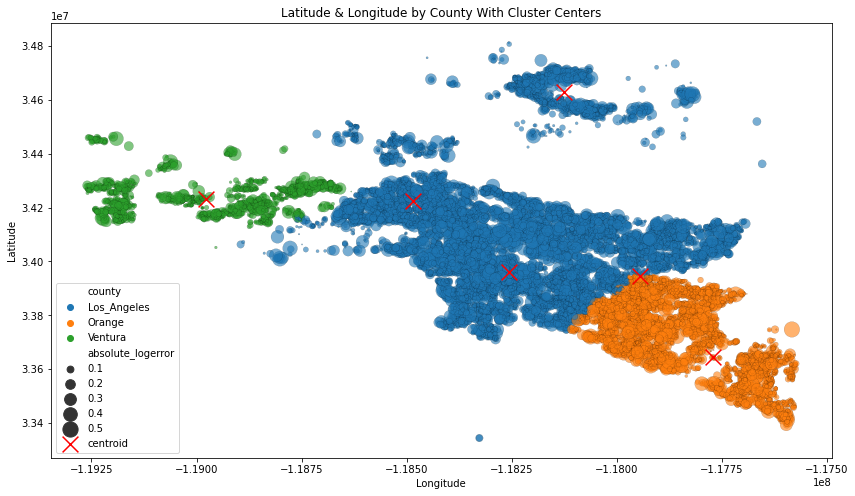

In [13]:
# Plot the data

train['absolute_logerror'] = abs(train['logerror'])
plt.figure(figsize = (14, 8))
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'county', data = train, ec = 'black', linewidth = 0.15, alpha = 0.6, size = 'absolute_logerror', sizes = (0, 250))
centroids.plot.scatter(x = 'longitude', y = 'latitude', c = 'red', marker = 'x', s = 250, ax = plt.gca(), label = 'centroid')

plt.legend()
plt.title('Latitude & Longitude by County With Cluster Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
train.drop(columns = ['absolute_logerror'], inplace = True)

### Takeaways

- The majority of errors follows dataset population: LA then Orange, then Ventura
- There seems to be bigger logerror concentrations in LA compared to the other two counties but it might be because there's more datapoints in LA.
- There isn't a clear relationship between logerror and latitude and longitude

### Question 2
**What is the relationship between the number of rooms a home has and logerror?**

In [14]:
# View how many of each for bedroom count

train.bedroomcnt.value_counts()

3.0    12462
4.0     7933
2.0     4250
5.0     1694
1.0      275
6.0      207
Name: bedroomcnt, dtype: int64

In [15]:
# let's bin the roomcnt feature into room groups.
train['bedroomcnt_binned'] = pd.cut(train.bedroomcnt, [0, 1, 2, 3, 4, 5, 6])

In [16]:
train.drop(columns = ['bedroomcnt_binned'], inplace = True)

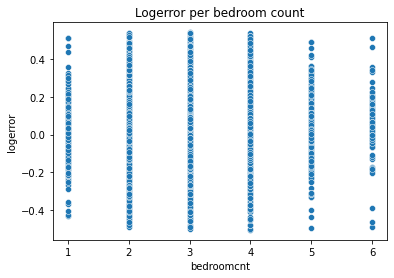

In [17]:
sns.scatterplot(x= 'bedroomcnt', y='logerror', data=train)
plt.title('Logerror per bedroom count')
plt.xlabel('bedroomcnt') 
plt.ylabel('logerror')
plt.show()

### Question 3

- What is the relationship between square feet and logerror?



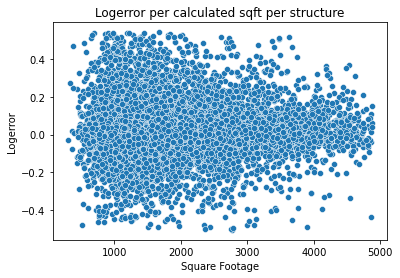

In [18]:
# What is the interaction of the variable with the target (Bivariate)
sns.scatterplot(x= 'calculatedfinishedsquarefeet', y='logerror', data=train)
plt.title('Logerror per calculated sqft per structure')
plt.xlabel('Square Footage') 
plt.ylabel('Logerror')
plt.show()

### Question 4

- How different are the logerrors for the three counties in the dataset?

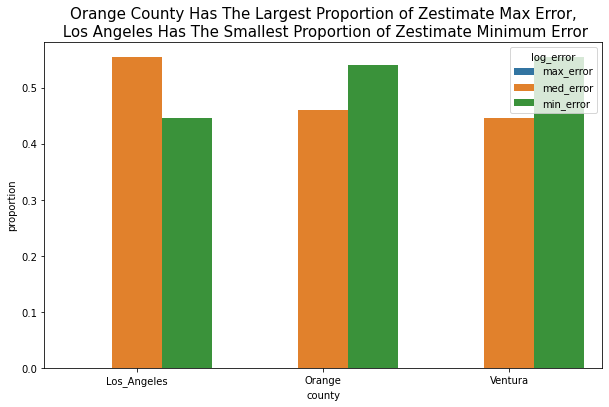

In [19]:
## add a column that bins each value of logerror into max, min, or med absolute error
train['log_error'] = pd.cut(train.logerror, bins=[-5,-1,-.03,.03,1,5], ordered=False, labels=['max_error','med_error','min_error','med_error','max_error'])

# plot the data to see if any county has a higher percentage of max logerrors
x, y, hue = 'county', 'proportion', 'log_error'
hue_order = ['max_error', 'med_error', 'min_error']

plt.figure(figsize=(10,6))
(train[hue]
 .groupby(train[x])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
plt.title('Orange County Has The Largest Proportion of Zestimate Max Error,\n Los Angeles Has The Smallest Proportion of Zestimate Minimum Error', size=15);

## Scale

# Model

### Baseline

## Conclusion Summary
- x

- x model had better accuracy than any other model

## Conclusion Recommendations
- x
- x

## Conclusion Next Steps

- x
- With more time x